In [1]:
# Heat flux calculation for Stratification case
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def Hflux_ts(datapath, case_id, xidx):
    State01 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    Adv01 = xr.open_dataset(datapath+'/Adv_' + str(format(case_id,'03d')) + '.nc')
    Grid01 = xr.open_dataset(datapath+'/grid_' + str(format(case_id,'03d')) + '.nc')
    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    Adv = Adv01.isel(T=~Adv01.get_index("T").duplicated())
    
    state = State.isel(T=range(1,len(State.T)))
    areaW = Grid01.HFacW * Grid01.drF * Grid01.dyG # Z Y Xp1
    u = state.U.data
    
    time = Adv.T.data / 86400
    Cp = 3994  # Specific heat content J/kg/C
    rho = 999.8 # Density
    
    advp = np.zeros(len(time)) # Positive advective heat flux
    advn = np.zeros(len(time)) # Negative advective heat flux
    Qp = np.zeros(len(time)) # Positive diffusive heat flux
    Qn = np.zeros(len(time)) # Negative diffusive heat flux
    
    AdvH = np.zeros(len(time)) # Advective heat flux
    
    for t in range(len(time)):
        
        advx = Adv.ADVx_TH.data[t,:,:,xidx] * Cp * rho
        #Qx = state.U.data[t,:,:,xidx] * areaW.data[:,:,xidx]
        
        advp[t] = advx[advx>0].sum()
        advn[t] = advx[advx<0].sum()
        AdvH[t] = advx.sum()
        
        #Qp[t] = Qx[Qx>0].sum()
        #Qn[t] = Qx[Qx<0].sum()
        
    return time, advp, advn

In [3]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs'

gf, sw, sc, se = 6, 120, 178, 235 # index for cross-fjord sections 0, 1, sill crest, 2

time, advpS0_1, advnS0_1 = Hflux_ts(path1, 1, gf)
time, advpS1_1, advnS1_1 = Hflux_ts(path1, 1, sw)
time, advpS0_2, advnS0_2 = Hflux_ts(path1, 4, gf)
time, advpS1_2, advnS1_2 = Hflux_ts(path1, 4, sw)

In [4]:
HS0_1 = advpS0_1 + advnS0_1
HS1_1 = advpS1_1 + advnS1_1
HS0_2 = advpS0_2 + advnS0_2
HS1_2 = advpS1_2 + advnS1_2
Hs1 = advnS0_1 - advnS1_1
Hs2 = advnS0_2 - advnS1_2

In [ ]:
HS0_2, HS1_2

Text(0.5, 0, 'Time [days]')

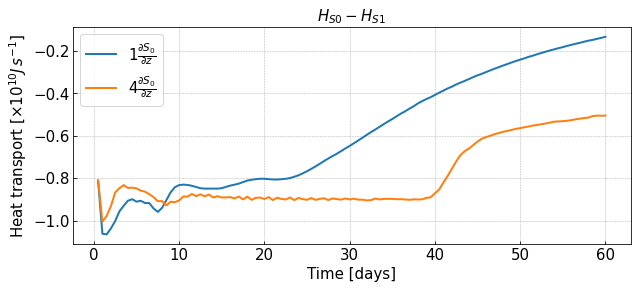

In [5]:
fig1 = plt.figure(figsize=(10,4))

ax0 = fig1.add_subplot(111)

ax0.plot(time, (HS0_2-HS1_2)/1e10, lw=2, label=r'$1\frac{\partial S_0}{\partial z}$')
ax0.plot(time, (HS0_1-HS1_1)/1e10, lw=2, label=r'$4\frac{\partial S_0}{\partial z}$')

plt.grid(linestyle = '--', linewidth = 0.5)
ax0.legend(loc='best',fontsize=15)
#ax0.set_xlim(time[59],time[-1])
#ax0.set_ylim(depth[-1],depth[0])
ax0.tick_params(direction='in', labelsize=15)
ax0.set_title(r'$H_{S0}-H_{S1}$', size=15, weight='bold')
ax0.set_ylabel(r'Heat transport [$\times 10^{10}J\,s^{-1}$]', size=15)
ax0.set_xlabel('Time [days]', size=15)


In [6]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig1.savefig(fig_path + '/netHeat.png', dpi=300, bbox_inches='tight')